In [1]:
# ================= TrendPulse: E-Commerce Analytics ===================
# Author: [Your Name]
# Description: Full analytics + visualization pipeline
# ======================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_palette("muted")


In [5]:
# Load your dataset (update path as needed)
df = pd.read_csv("ecommerce_transactions.csv")

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Parse date
df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce")

print("✅ Data loaded successfully!")
df.head()


✅ Data loaded successfully!


,transaction_id,user_name,age,country,product_category,purchase_amount,payment_method,transaction_date
0,1,Ava Hall,63,Mexico,Clothing,780.69,Debit Card,2023-04-14
1,2,Sophia Hall,59,India,Beauty,738.56,PayPal,2023-07-30
2,3,Elijah Thompson,26,France,Books,178.34,Credit Card,2023-09-17
3,4,Elijah White,43,Mexico,Sports,401.09,UPI,2023-06-21
4,5,Ava Harris,48,Germany,Beauty,594.83,Net Banking,2024-10-29


In [8]:
df = df.dropna(subset=["transaction_date"])
df = df.sort_values("transaction_date")

print("Data shape:", df.shape)
print("Date range:", df["transaction_date"].min(), "→", df["transaction_date"].max())
print("Unique customers:", df["user_name"].nunique())
print("Countries:", df["country"].nunique())
print("Categories:", df["product_category"].nunique())

# Derived features
df["order_month"] = df["transaction_date"].dt.to_period("M")
df["year"] = df["transaction_date"].dt.year
df["month"] = df["transaction_date"].dt.month


Data shape: (50000, 8)
Date range: 2023-03-09 00:00:00 → 2025-03-08 00:00:00
Unique customers: 100
Countries: 10
Categories: 8


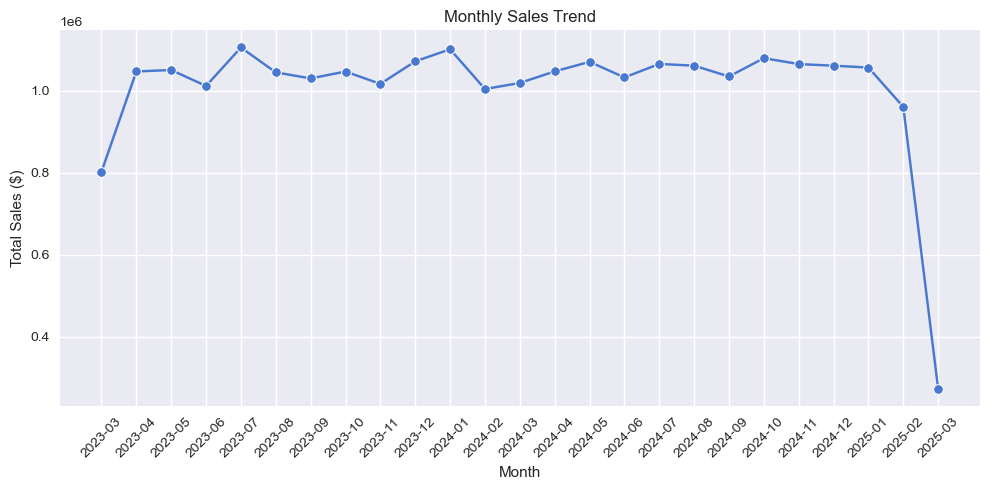

In [10]:
sales_by_month = df.groupby("order_month")["purchase_amount"].sum().reset_index()
sales_by_month["order_month"] = sales_by_month["order_month"].astype(str)

plt.figure(figsize=(10,5))
sns.lineplot(data=sales_by_month, x="order_month", y="purchase_amount", marker="o")
plt.title("Monthly Sales Trend")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.tight_layout()
plt.show()


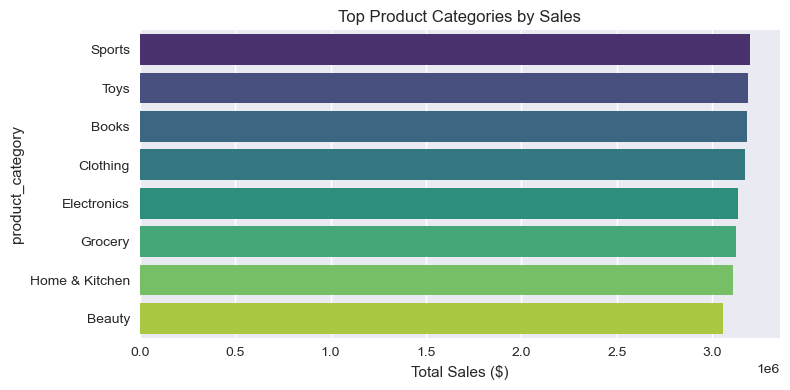

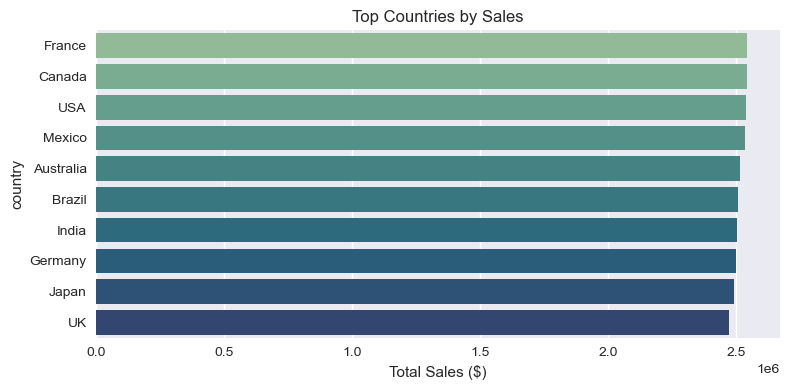

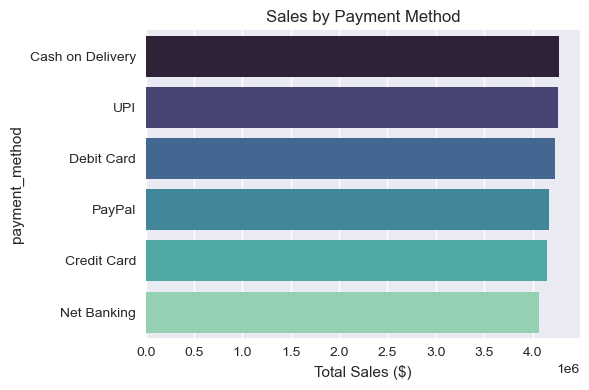

In [12]:
# Category
top_cat = df.groupby("product_category")["purchase_amount"].sum().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=top_cat.values, y=top_cat.index, palette="viridis")
plt.title("Top Product Categories by Sales")
plt.xlabel("Total Sales ($)")
plt.tight_layout()
plt.show()

# Country
top_country = df.groupby("country")["purchase_amount"].sum().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=top_country.values, y=top_country.index, palette="crest")
plt.title("Top Countries by Sales")
plt.xlabel("Total Sales ($)")
plt.tight_layout()
plt.show()

# Payment Methods
pay_pref = df.groupby("payment_method")["purchase_amount"].sum().sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=pay_pref.values, y=pay_pref.index, palette="mako")
plt.title("Sales by Payment Method")
plt.xlabel("Total Sales ($)")
plt.tight_layout()
plt.show()


✅ RFM Analysis Completed Successfully!
      user_name  Recency  Frequency   Monetary R_rank F_rank M_rank  RFM_Sum
0     Ava Allen        1        494  247865.13      4      2      2        8
1  Ava Anderson        1        491  246801.09      4      2      2        8
2     Ava Clark        2        517  273776.79      3      4      4       11
3      Ava Hall        6        517  268756.73      1      4      4        9
4    Ava Harris        4        520  266846.08      1      4      4        9


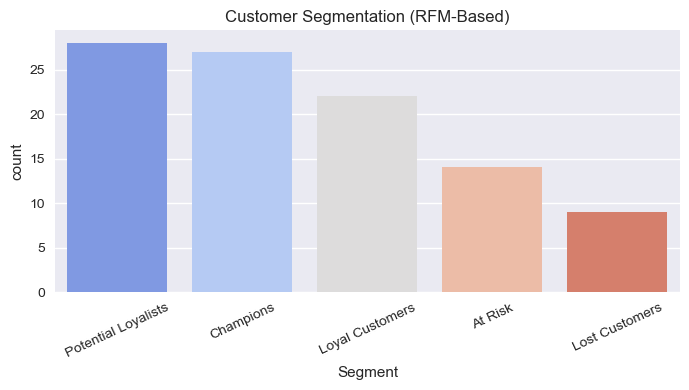

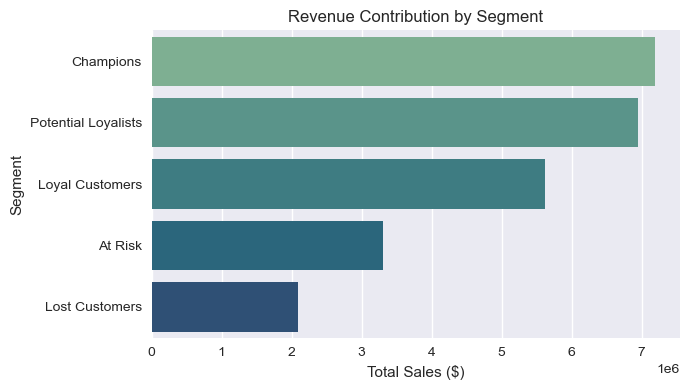

✅ Segmentation Completed. Segment Distribution:
Segment
Potential Loyalists    28
Champions              27
Loyal Customers        22
At Risk                14
Lost Customers          9
Name: count, dtype: int64


In [16]:
# ==========================================================
# STEP 6: RFM (Recency, Frequency, Monetary) Analysis - FIXED
# ==========================================================

# Snapshot date = day after last transaction
snapshot_date = df["transaction_date"].max() + pd.Timedelta(days=1)

# Compute Recency, Frequency, Monetary
rfm = df.groupby("user_name").agg({
    "transaction_date": lambda x: (snapshot_date - x.max()).days,  # Recency
    "transaction_id": "count",                                     # Frequency
    "purchase_amount": "sum"                                       # Monetary
}).reset_index()

rfm.columns = ["user_name", "Recency", "Frequency", "Monetary"]

# -----------------------------
# Handle duplicate bin edges safely
# -----------------------------
rfm["R_rank"] = pd.qcut(rfm["Recency"].rank(method="first"), 4, labels=[4,3,2,1], duplicates="drop")
rfm["F_rank"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4], duplicates="drop")
rfm["M_rank"] = pd.qcut(rfm["Monetary"].rank(method="first"), 4, labels=[1,2,3,4], duplicates="drop")

# Compute RFM Score
rfm["RFM_Sum"] = rfm[["R_rank","F_rank","M_rank"]].astype(int).sum(axis=1)

print("✅ RFM Analysis Completed Successfully!")
print(rfm.head())

# ==========================================================
# STEP 7: CUSTOMER SEGMENTATION
# ==========================================================

def segment_customer(row):
    if row['RFM_Sum'] >= 10:
        return 'Champions'
    elif 8 <= row['RFM_Sum'] < 10:
        return 'Loyal Customers'
    elif 6 <= row['RFM_Sum'] < 8:
        return 'Potential Loyalists'
    elif 4 <= row['RFM_Sum'] < 6:
        return 'At Risk'
    else:
        return 'Lost Customers'

rfm["Segment"] = rfm.apply(segment_customer, axis=1)

# -----------------------------
# Visualization - Customer Count by Segment
# -----------------------------
plt.figure(figsize=(7,4))
sns.countplot(data=rfm, x="Segment", order=rfm["Segment"].value_counts().index, palette="coolwarm")
plt.title("Customer Segmentation (RFM-Based)")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# -----------------------------
# Visualization - Revenue Contribution by Segment
# -----------------------------
seg_sales = rfm.groupby("Segment")["Monetary"].sum().sort_values(ascending=False)
plt.figure(figsize=(7,4))
sns.barplot(x=seg_sales.values, y=seg_sales.index, palette="crest")
plt.title("Revenue Contribution by Segment")
plt.xlabel("Total Sales ($)")
plt.tight_layout()
plt.show()

print("✅ Segmentation Completed. Segment Distribution:")
print(rfm["Segment"].value_counts())



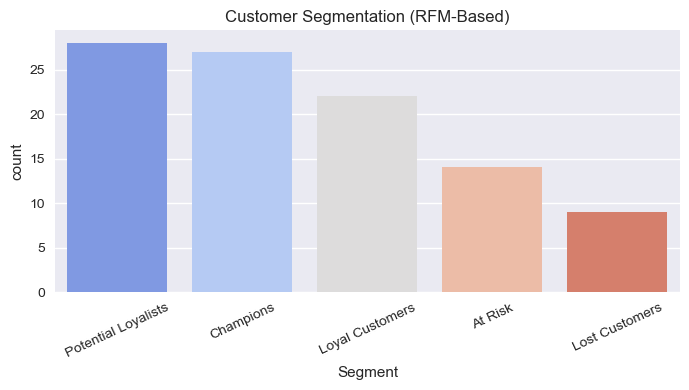

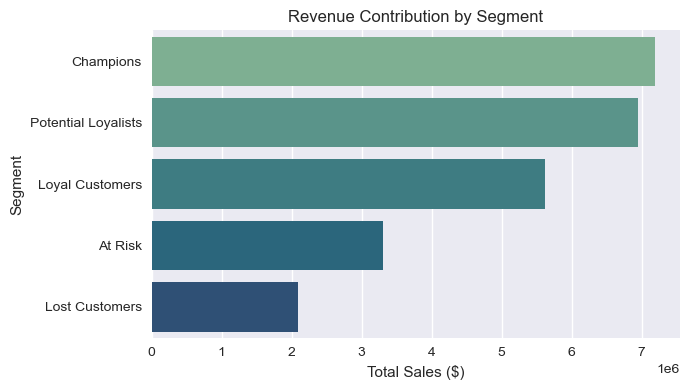

In [18]:
def segment_customer(row):
    if row['RFM_Sum'] >= 10:
        return 'Champions'
    elif 8 <= row['RFM_Sum'] < 10:
        return 'Loyal Customers'
    elif 6 <= row['RFM_Sum'] < 8:
        return 'Potential Loyalists'
    elif 4 <= row['RFM_Sum'] < 6:
        return 'At Risk'
    else:
        return 'Lost Customers'

rfm["Segment"] = rfm.apply(segment_customer, axis=1)

plt.figure(figsize=(7,4))
sns.countplot(data=rfm, x="Segment", order=rfm["Segment"].value_counts().index, palette="coolwarm")
plt.title("Customer Segmentation (RFM-Based)")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

seg_sales = rfm.groupby("Segment")["Monetary"].sum().sort_values(ascending=False)
plt.figure(figsize=(7,4))
sns.barplot(x=seg_sales.values, y=seg_sales.index, palette="crest")
plt.title("Revenue Contribution by Segment")
plt.xlabel("Total Sales ($)")
plt.tight_layout()
plt.show()


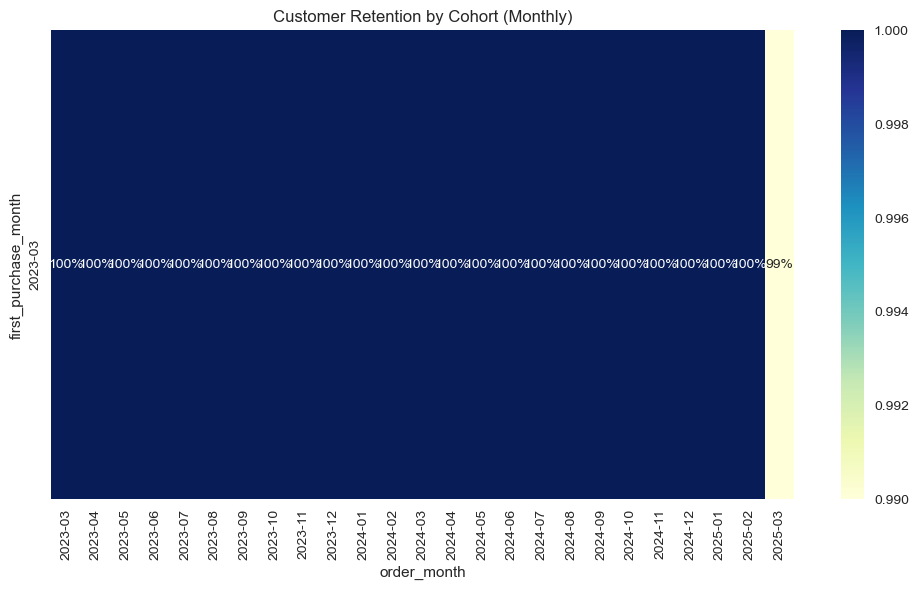

In [20]:
df["first_purchase_month"] = df.groupby("user_name")["transaction_date"].transform("min").dt.to_period("M")
df["order_month"] = df["transaction_date"].dt.to_period("M")

cohort_data = df.groupby(["first_purchase_month", "order_month"])["user_name"].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index="first_purchase_month", columns="order_month", values="user_name")
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

plt.figure(figsize=(10,6))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title("Customer Retention by Cohort (Monthly)")
plt.tight_layout()
plt.show()


## Forecasting Future Sales ##

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.3 MB 1.3 MB/s eta 0:00:10
   - -------------------------------------- 0.5/13.3 MB 1.3 MB/s eta 0:00:10
   - -------------------------------------- 0.5/13.3 MB 1.3 MB/s eta 0:00:10
   --- ------------------------------------ 1.0/13.3 MB 838.4 kB/s eta 0:00:15
   --- ------------------------------------ 1.3/13.3 MB 882.6 kB/s eta 0:00:14
   ---- ----------------------------------- 1.6/13.3 MB 942.3 kB/s eta 0:00:13
   ----- ---------------------------------- 1.8/13.3 MB 976.9 kB/s eta 0:00:12
   ------ --------------------------------- 2.1/13.3 MB 1.0 MB/s eta 0:00:12
   ------- -------------------------------- 2.4/13.3 MB 1.0 MB/s eta 0:00:11
   ------- -------------------------------- 2.6/13.3 MB 1.0 MB/s eta 0:00:11
   -------- 

00:35:56 - cmdstanpy - INFO - Chain [1] start processing
00:35:57 - cmdstanpy - INFO - Chain [1] done processing


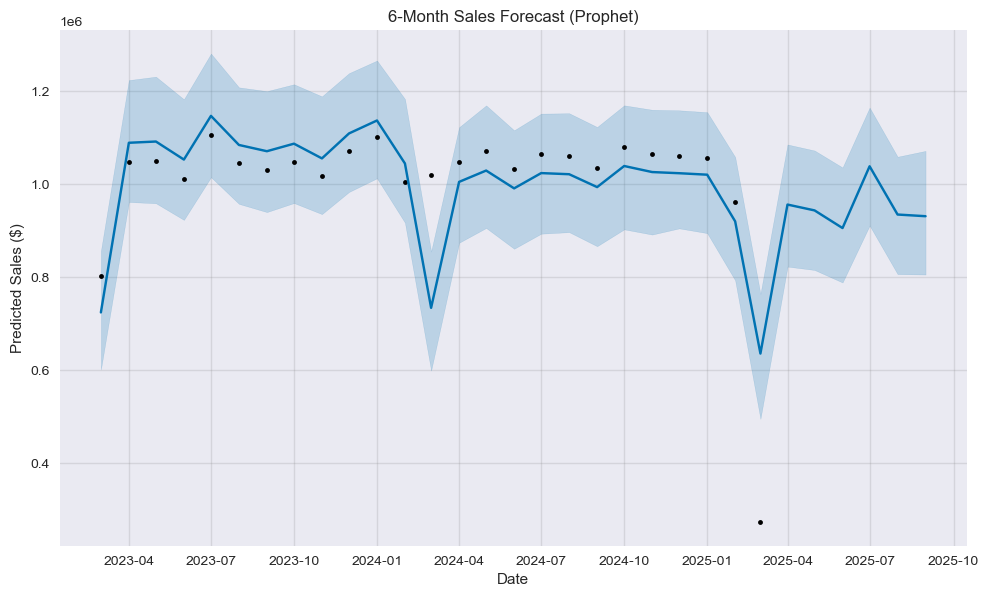

In [22]:
!pip install prophet
from prophet import Prophet

sales_df = sales_by_month.rename(columns={"order_month":"ds", "purchase_amount":"y"})
sales_df["ds"] = pd.to_datetime(sales_df["ds"])

m = Prophet()
m.fit(sales_df)
future = m.make_future_dataframe(periods=6, freq="M")
forecast = m.predict(future)

fig = m.plot(forecast)
plt.title("6-Month Sales Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Predicted Sales ($)")
plt.show()


In [25]:
total_sales = df["purchase_amount"].sum()
unique_customers = df["user_name"].nunique()
avg_order_value = df["purchase_amount"].mean()
top_category = df.groupby("product_category")["purchase_amount"].sum().idxmax()
top_country = df.groupby("country")["purchase_amount"].sum().idxmax()

print("📈 --- BUSINESS KPI SUMMARY ---")
print(f"💰 Total Sales: ${total_sales:,.0f}")
print(f"👥 Unique Customers: {unique_customers}")
print(f"🛍️ Average Order Value: ${avg_order_value:,.2f}")
print(f"🏆 Top Category: {top_category}")
print(f"🌍 Top Country: {top_country}")


📈 --- BUSINESS KPI SUMMARY ---
💰 Total Sales: $25,157,990
👥 Unique Customers: 100
🛍️ Average Order Value: $503.16
🏆 Top Category: Sports
🌍 Top Country: France
